In [21]:
# 0) Imports
import numpy as np, random, torch, pandas as pd, math
import torch, torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time

In [22]:
df1 = pd.read_excel("./cleaned.xlsx")
print(df1.head())

       TIMESTAMP  TARGETVAR       U10       V10      U100      V100  \
0  20120101 1:00   0.000000  2.124600 -2.681966  2.864280 -3.666076   
1  20120101 2:00   0.054879  2.521695 -1.796960  3.344859 -2.464761   
2  20120101 3:00   0.110234  2.672210 -0.822516  3.508448 -1.214093   
3  20120101 4:00   0.165116  2.457504 -0.143642  3.215233 -0.355546   
4  20120101 5:00   0.156940  2.245898  0.389576  2.957678  0.332701   

             DATETIME  
0 2012-01-01 01:00:00  
1 2012-01-01 02:00:00  
2 2012-01-01 03:00:00  
3 2012-01-01 04:00:00  
4 2012-01-01 05:00:00  


In [23]:
# =========================
# 1) Load & clean
# =========================
df = pd.read_excel("./WindPowerForecastingData.xlsx")
df["DATETIME"] = pd.to_datetime(df["TIMESTAMP"], format="%Y%m%d %H:%M", errors="coerce")
df = df.sort_values("DATETIME").reset_index(drop=True)

TARGET_COL = "TARGETVAR"  # change this to actual target column name
df_clean = df.drop(columns=[c for c in ["TIMESTAMP","DATETIME"] if c in df.columns]).copy()
cols = [TARGET_COL] + [c for c in df_clean.columns if c != TARGET_COL]
df_clean = df_clean[cols].astype(float)

##############3
n_before = len(df_clean)
df_clean = df_clean.dropna(subset=[TARGET_COL]).copy()
print(f"Dropped {n_before - len(df_clean)} rows with missing target.")
##############

print (df_clean.head())
# =========================
# 2) Chronological split
# =========================
n = len(df_clean)
train_n = int(0.8 * n)
train_df = df_clean.iloc[:train_n].copy()
test_df  = df_clean.iloc[train_n:].copy()
print(".......................")
print(train_df[[TARGET_COL]])
y_train = train_df[[TARGET_COL]].values
print(".....y train ..................")
print(y_train)
X_train = train_df.drop(columns=[TARGET_COL]).values
print(".....x train ..................")
print(X_train)
y_test  = test_df[[TARGET_COL]].values
X_test  = test_df.drop(columns=[TARGET_COL]).values

print(".....size ..................")
print("y_train shape:", y_train.shape)
print("y_train min/max:", np.nanmin(y_train), np.nanmax(y_train))
print(".....end size ..................")

x_scaler = MinMaxScaler().fit(X_train)
#y_scaler = MinMaxScaler().fit(y_train)

X_train_s = x_scaler.transform(X_train)
X_test_s  = x_scaler.transform(X_test)
# y_train_s = y_scaler.transform(y_train)
# y_test_s  = y_scaler.transform(y_test)

print("y_train min/max:", y_train.min(), y_train.max())
print("X_train min/max:", X_train.min(), X_train.max())


Dropped 35 rows with missing target.
   TARGETVAR       U10       V10      U100      V100
0   0.000000  2.124600 -2.681966  2.864280 -3.666076
1   0.054879  2.521695 -1.796960  3.344859 -2.464761
2   0.110234  2.672210 -0.822516  3.508448 -1.214093
3   0.165116  2.457504 -0.143642  3.215233 -0.355546
4   0.156940  2.245898  0.389576  2.957678  0.332701
.......................
       TARGETVAR
0       0.000000
1       0.054879
2       0.110234
3       0.165116
4       0.156940
...          ...
13414   0.665915
13415   0.758011
13416   0.862043
13417   0.896250
13418   0.807067

[13412 rows x 1 columns]
.....y train ..................
[[0.        ]
 [0.05487912]
 [0.110234  ]
 ...
 [0.86204301]
 [0.89625034]
 [0.807067  ]]
.....x train ..................
[[ 2.12460014 -2.68196637  2.86427959 -3.66607576]
 [ 2.52169465 -1.79696009  3.34485867 -2.46476146]
 [ 2.67220986 -0.82251622  3.50844802 -1.21409294]
 ...
 [-3.47043383 -4.0529605  -5.47409945 -7.29139776]
 [-3.93802336 -3.85843369 -6

In [24]:
#reproducibility & device
SEED = 42
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED) #creates the same sequences acroess the numpy and python
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED) #since the starting weights are randomly initialized,  these starting weights are the same every single time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cpu


In [25]:
# data helpers
def make_sequences(X, y, lookback):
    """
    Create the sequences for machine learning training
    X : input features 
    Y : target variable
    lookback : the amount of data used for training (eg : previous 12 hour data)
    """
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i, :])
        ys.append(y[i, 0])
    return np.array(Xs, np.float32), np.array(ys, np.float32).reshape(-1,1)

def build_lstm_pack(input_size, hidden_size, num_layers, dropout):
    # nn.LSTM's internal dropout works only if num_layers > 1
    lstm = nn.LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
        dropout=(dropout if num_layers > 1 else 0.0)
    ).to(device)
    fc = nn.Linear(hidden_size, 1).to(device)
    return lstm, fc

In [30]:
def train_once(X_train_s, y_train, X_test_s, y_test,
               lookback, hidden_size, num_layers, dropout,
               lr, batch_size, weight_decay,
               max_epochs=100, patience=5, min_delta=1e-4):
    """
    Early-stops when validation loss is non-decreasing for `patience` consecutive epochs.
    'Non-decreasing' means: current_val >= previous_val - min_delta
    """

    # ---------- make sequences ----------
    n_tr = len(X_train_s)
    val_len = max(1, int(0.2 * n_tr))
    X_core, y_core = X_train_s[:n_tr - val_len], y_train[:n_tr - val_len]
    X_val,  y_val  = X_train_s[n_tr - val_len:], y_train[n_tr - val_len:]

    Xtr_seq, ytr_seq = make_sequences(X_core, y_core, lookback)
    Xva_seq, yva_seq = make_sequences(X_val,  y_val,  lookback)
    Xte_seq, yte_seq = make_sequences(X_test_s, y_test, lookback)

    train_loader = DataLoader(TensorDataset(torch.from_numpy(Xtr_seq), torch.from_numpy(ytr_seq)),
                              batch_size=batch_size, shuffle=False, drop_last=False)
    val_loader   = DataLoader(TensorDataset(torch.from_numpy(Xva_seq), torch.from_numpy(yva_seq)),
                              batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader  = DataLoader(TensorDataset(torch.from_numpy(Xte_seq), torch.from_numpy(yte_seq)),
                              batch_size=batch_size, shuffle=False, drop_last=False)

    # ---------- model, opt, sched ----------
    input_size = X_train_s.shape[1]
    lstm, fc = build_lstm_pack(input_size, hidden_size, num_layers, dropout)
    params = list(lstm.parameters()) + list(fc.parameters())
    opt = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5)
    loss_fn = nn.MSELoss()

    best_val = float('inf')
    best_state = None

    # for "flat or up" detection
    prev_val = None
    nondec_streak = 0  # consecutive epochs with val not improving

    for ep in range(1, max_epochs + 1):
        # ----- train -----
        lstm.train(); fc.train()
        train_loss_sum = 0.0
        n_train_batches = 0
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad()
            pred = forward_pass_single(lstm, fc, xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(params, max_norm=1.0)
            opt.step()
            train_loss_sum += loss.item()
            n_train_batches += 1
        train_mse = train_loss_sum / max(1, n_train_batches)

        # ----- validate -----
        lstm.eval(); fc.eval()
        val_loss_sum = 0.0
        n_val_batches = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device); yb = yb.to(device)
                pred = forward_pass_single(lstm, fc, xb)
                vloss = loss_fn(pred, yb).item()
                val_loss_sum += vloss
                n_val_batches += 1
        val_mse = val_loss_sum / max(1, n_val_batches)
        sch.step(val_mse)

        # ----- logging -----
        print(f"Epoch {ep:03d}/{max_epochs} | train_mse={train_mse:.6f} | val_mse={val_mse:.6f} | best_val={best_val if best_val<1e18 else float('nan'):.6f} | nondec={nondec_streak}/{patience}")

        # ----- improvement check -----
        # improvement only if it beats best_val by at least min_delta
        if val_mse < (best_val - min_delta):
            best_val = val_mse
            best_state = {
                "lstm": {k: v.detach().cpu().clone() for k, v in lstm.state_dict().items()},
                "fc":   {k: v.detach().cpu().clone() for k, v in fc.state_dict().items()},
            }
            nondec_streak = 0
        else:
            nondec_streak += 1

        # also consider "flat or increasing vs previous epoch"
        if prev_val is not None and val_mse >= (prev_val - min_delta):
            # this epoch is not better than the previous one by min_delta either
            pass  # the nondec_streak already counts "no new best"; keep logic simple
        prev_val = val_mse

        # ----- early stop on flat/up -----
        if nondec_streak >= patience:
            print(f"[Early Stop] Validation loss was flat/increasing for {patience} consecutive epochs (min_delta={min_delta}).")
            break

    # restore best weights
    if best_state is not None:
        lstm.load_state_dict(best_state["lstm"])
        fc.load_state_dict(best_state["fc"])

    model_pack = (lstm, fc)
    return math.sqrt(best_val), model_pack, test_loader


### Use of Genetic algorithm for hyper parameter tuning

 Instead of manually trying different combinations of lookback and hidden layer sizes (h1, h2, h3), the GA automates  process by treating each combination as a "genome" and "evolving" a population of models over several generations to find the one with the best performance.



<p align="center">
  <img src="genetic.png" alt="Diagram" />
</p>


In [31]:
N_STEPS_CHOICES   = [12, 24, 48]
HIDDEN_CHOICES    = [64, 128, 192]
NUM_LAYERS_CHOICES= [1, 2]
DROPOUT_CHOICES   = [0.0, 0.1, 0.2]     # effective only if num_layers > 1 (internal LSTM dropout)
BATCH_CHOICES     = [32, 64]
LR_CHOICES        = [5e-4, 1e-3, 2e-3]
WD_CHOICES        = [0.0, 1e-4, 5e-4]

# Genome: (n_steps, hidden_size, num_layers, dropout, batch_size, lr, weight_decay)
def random_individual():
    return (
        random.choice(N_STEPS_CHOICES),
        random.choice(HIDDEN_CHOICES),
        random.choice(NUM_LAYERS_CHOICES),
        random.choice(DROPOUT_CHOICES),
        random.choice(BATCH_CHOICES),
        random.choice(LR_CHOICES),
        random.choice(WD_CHOICES),
    )

GA_POP = 10
GA_GENS = 6
GA_CX_RATE  = 0.4
GA_MUT_RATE = 0.10

def crossover(p1, p2):
    if random.random() > GA_CX_RATE: return p1, p2
    cut = random.randint(1, len(p1)-1)
    return (p1[:cut] + p2[cut:], p2[:cut] + p1[cut:])

def mutate(ind):
    pools = [N_STEPS_CHOICES, HIDDEN_CHOICES, NUM_LAYERS_CHOICES,
             DROPOUT_CHOICES, BATCH_CHOICES, LR_CHOICES, WD_CHOICES]
    ind = list(ind)
    for g in range(len(ind)):
        if random.random() < GA_MUT_RATE:
            choices = [x for x in pools[g] if x != ind[g]]
            ind[g] = random.choice(choices)
    return tuple(ind)

def tournament_select(pop, fits, k=3):
    idxs = random.sample(range(len(pop)), k)
    idxs.sort(key=lambda i: fits[i])
    return pop[idxs[0]]

def run_ga():
    pop = [random_individual() for _ in range(GA_POP)]
    best = (np.inf, None, None, None)  # (val_rmse, ind, model_pack, test_loader)
    cache = {}

    for gen in range(GA_GENS):
        fits, packs, tls = [], [], []
        for i, ind in enumerate(pop):
            if ind in cache:
                val_rmse, model_pack, tl = cache[ind]
            else:
                print(f"[Gen {gen+1}/{GA_GENS}] Eval {i+1}/{len(pop)}: {ind}")
                val_rmse, model_pack, tl = train_once(
                    X_train_s, y_train, X_test_s, y_test,
                    lookback=ind[0], hidden_size=ind[1], num_layers=ind[2], dropout=ind[3],
                    lr=ind[5], batch_size=ind[4], weight_decay=ind[6],
                    max_epochs=100, patience=15
                )
                cache[ind] = (val_rmse, model_pack, tl)
            fits.append(val_rmse); packs.append(model_pack); tls.append(tl)

        # update global best
        for ind, rmse, pack, tl in zip(pop, fits, packs, tls):
            if rmse < best[0]:
                best = (rmse, ind, pack, tl)
        print(f"  -> Best so far: RMSE={best[0]:.5f}, ind={best[1]}")

        # next generation: elites + tournament/cx/mut
        elite_idx = np.argsort(fits)[:2]
        new_pop = [pop[elite_idx[0]], pop[elite_idx[1]]]
        while len(new_pop) < GA_POP:
            p1 = tournament_select(pop, fits, k=3)
            p2 = tournament_select(pop, fits, k=3)
            c1, c2 = crossover(p1, p2)
            new_pop.extend([mutate(c1), mutate(c2)])
        pop = new_pop[:GA_POP]

    return best  # (best_val_rmse, best_individual, best_model_pack, best_test_loader)

# =========================
# Run GA, evaluate on TEST, save
# =========================
start = time.time()
best_val_rmse, best_ind, best_pack, best_test_loader = run_ga()
print("\n==== GA Best ====")
print("Best genome (n_steps, hidden_size, num_layers, dropout, batch, lr, weight_decay):", best_ind)
print(f"Best Val RMSE: {best_val_rmse:.6f} | Time: {(time.time()-start):.1f}s")

# Final TEST metrics
(lstm, fc) = best_pack
preds, trues = [], []
with torch.no_grad():
    lstm.eval(); fc.eval()
    for xb, yb in best_test_loader:
        xb = xb.to(device); yb = yb.to(device)
        pb = forward_pass_single(lstm, fc, xb)
        preds.append(pb.cpu().numpy()); trues.append(yb.cpu().numpy())
y_true = np.vstack(trues).reshape(-1)
y_pred = np.vstack(preds).reshape(-1)

rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
mae  = float(mean_absolute_error(y_true, y_pred))
eps  = 1e-6
smape = float(np.mean(2*np.abs(y_pred - y_true)/(np.abs(y_true)+np.abs(y_pred)+eps))*100)
print(f"\n=== TEST ===\nRMSE={rmse:.6f} | MAE={mae:.6f} | sMAPE={smape:.2f}%")

# Save checkpoint
torch.save({
    "lstm": lstm.state_dict(),
    "fc":   fc.state_dict(),
    "arch": {
        "input_size": X_train_s.shape[1],
        "lookback": best_ind[0],
        "hidden_size": best_ind[1],
        "num_layers": best_ind[2],
        "dropout": best_ind[3]
    },
    "optim": {"lr": best_ind[5], "weight_decay": best_ind[6], "batch_size": best_ind[4]}
}, "ga_lstm_best_optionA.pth")
print("Saved -> ga_lstm_best_optionA.pth")




[Gen 1/6] Eval 1/10: (12, 192, 2, 0.2, 64, 0.0005, 0.0001)
Epoch 001/100 | train_mse=0.083433 | val_mse=0.066256 | best_val=nan | nondec=0/15
Epoch 002/100 | train_mse=0.071420 | val_mse=0.064420 | best_val=0.066256 | nondec=0/15
Epoch 003/100 | train_mse=0.068229 | val_mse=0.063126 | best_val=0.064420 | nondec=0/15
Epoch 004/100 | train_mse=0.067465 | val_mse=0.062152 | best_val=0.063126 | nondec=0/15
Epoch 005/100 | train_mse=0.066754 | val_mse=0.060881 | best_val=0.062152 | nondec=0/15
Epoch 006/100 | train_mse=0.066220 | val_mse=0.059928 | best_val=0.060881 | nondec=0/15
Epoch 007/100 | train_mse=0.065946 | val_mse=0.059127 | best_val=0.059928 | nondec=0/15
Epoch 008/100 | train_mse=0.065246 | val_mse=0.058682 | best_val=0.059127 | nondec=0/15
Epoch 009/100 | train_mse=0.064667 | val_mse=0.058735 | best_val=0.058682 | nondec=0/15
Epoch 010/100 | train_mse=0.064232 | val_mse=0.058533 | best_val=0.058682 | nondec=1/15
Epoch 011/100 | train_mse=0.063793 | val_mse=0.058368 | best_val=0

KeyboardInterrupt: 

RMSE=0.202002 | MAE=0.153331 | sMAPE=61.59%


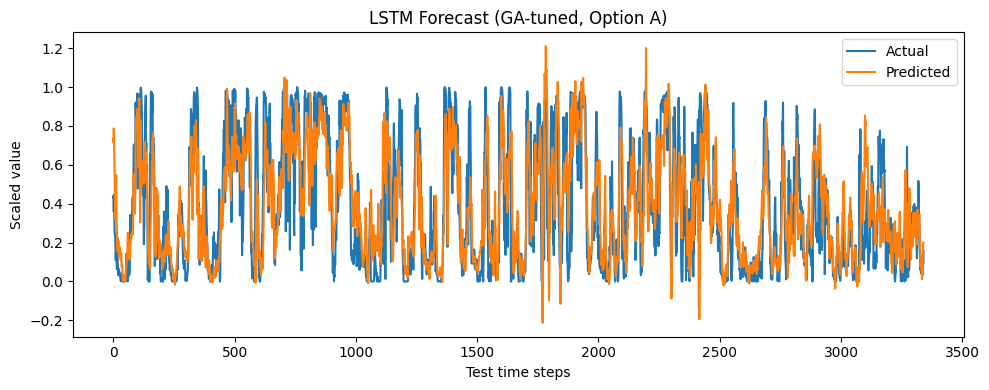

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# y_true, y_pred already built; TARGET_COL is your target's name
yt = np.asarray(y_true).reshape(-1)
yp = np.asarray(y_pred).reshape(-1)

# Basic metrics (on original scale)
rmse = np.sqrt(np.mean((yt - yp)**2))
#rmse = mean_squared_error(yt, yp, squared=False)
mae  = mean_absolute_error(yt, yp)
eps  = 1e-6
smape = np.mean(2*np.abs(yp - yt) / (np.abs(yt) + np.abs(yp) + eps)) * 100

print(f"RMSE={rmse:.6f} | MAE={mae:.6f} | sMAPE={smape:.2f}%")

# --- Plot: full test series ---
plt.figure(figsize=(10,4))
plt.plot(yt, label="Actual")
plt.plot(yp, label="Predicted")
plt.title("LSTM Forecast (GA-tuned, Option A)")
plt.xlabel("Test time steps"); plt.ylabel("Scaled value"); plt.legend(); plt.tight_layout()
plt.show()

# --- (Optional) Zoom into a window, e.g., first 500 points ---
# k = min(500, len(yt))
# plt.figure(figsize=(12,5))
# plt.plot(yt[:k], label="Actual", linewidth=1.2)
# plt.plot(yp[:k], label="Predicted", linewidth=1.2)
# plt.title(f"Zoomed view (first {k} steps)")
# plt.xlabel("Test time steps")
# plt.ylabel(TARGET_COL)
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# --- (Optional) Parity / scatter plot ---
# plt.figure(figsize=(5,5))
# plt.scatter(yt, yp, s=8, alpha=0.6)
# lims = [min(yt.min(), yp.min()), max(yt.max(), yp.max())]
# plt.plot(lims, lims, linestyle="--")  # y=x line
# plt.title("Predicted vs Actual")
# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


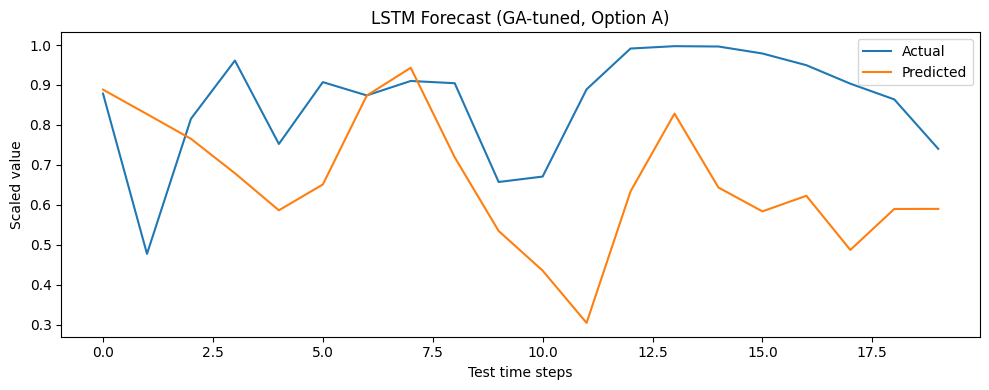

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(yt[100:120], label="Actual")
plt.plot(yp[100:120], label="Predicted")
plt.title("LSTM Forecast (GA-tuned, Option A)")
plt.xlabel("Test time steps"); plt.ylabel("Scaled value"); plt.legend(); plt.tight_layout()
plt.show()

In [ ]:
torch.save(lstm, "model.pth")

In [ ]:
torch.save({
    "lstm1": lstm_model.state_dict(),
    "fc": fc_model.state_dict(),
    # maybe optimizer, epoch etc.
}, "glstm_noclass_best.pth")
